In [1]:
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np
import scipy.signal as ss
import os
import warnings
warnings.filterwarnings("ignore")

from weight import array_weight_vector
from utils import find_position_vector, find_steering_matrix, Time, corelation, nsb, SINR, capon
from doa import music

repo_dir = os.getcwd()
tm = Time()

ModuleNotFoundError: No module named 'weight'

In [ ]:
print(adakjd)

## Sample Location Generation For Testing

In [2]:
%matplotlib notebook
np.random.seed(6)

P,Q = 8,8 # rows and columns of antenna array
lamda = 1 # wavelength
ue = 1  # number of user equipments
ris = 1  # number of RIS
n_source = ue+ris
n_antenna = P*Q  # number of antenna elements 
snr = 10

print('\nsimulation sample data\n----------------------')
array = np.linspace(0,(n_antenna-1)/2,n_antenna)

# angle for RIS would be added
p_thetas = (np.pi/3)*(np.random.rand(n_source))   # random source polar directions
az_thetas = (2*np.pi)*(np.random.rand(n_source))   # random source azimuthal directions

# power from RIS would be added
ue_alphas = np.sqrt(1/2)*(np.random.randn(ue) + np.random.randn(ue)*1j) # random UE powers
ris_alphas = np.sqrt(1/2)*(np.random.randn(ris) + np.random.randn(ris)*1j) # random RIS powers

print('random signal direction #polar:',p_thetas*180/np.pi)
print('random signal direction #azimuthal:',az_thetas*180/np.pi)

ue_vectors, ris_vectors = [],[]
ue_angles, ris_angles = [], []
for polar,az in zip(p_thetas[:ue],az_thetas[:ue]):
    ue_vectors.append(find_position_vector(polar,az))
    ue_angles.append([polar*180/np.pi,az*180/np.pi])

for polar,az in zip(p_thetas[ue:],az_thetas[ue:]):
    ris_vectors.append(find_position_vector(polar,az))
    ris_angles.append([polar*180/np.pi,az*180/np.pi])

bs_vector = [0,0,0]
print('\nbase station locations:',bs_vector)
print(f'\nRIS \ndirection vectors: {ris_vectors}\ndirection angles: {ris_angles}\npower: {ris_alphas}')
print(f'\nuser equipment \ndirection vectors: {ue_vectors}\ndirection angles: {ue_angles}\npower: {ue_alphas}')


simulation sample data
----------------------
random signal direction #polar: [53.57160909 19.91878832]
random signal direction #azimuthal: [295.6424843   15.01078526]

base station locations: [0, 0, 0]

RIS 
direction vectors: [[0.006067509241204117, 2.7744162567926823e-05, 0.9999815921115095]]
direction angles: [[19.918788318070632, 15.010785261089966]]
power: [-1.75841946+0.64576634j]

user equipment 
direction vectors: [[0.016251992379168842, 0.0014675892375824373, 0.999866850598387]]
direction angles: [[53.571609086160095, 295.64248430081943]]
power: [0.15402256-0.63575391j]


## Sample Data Generation

In [3]:
numAngles = 360
p_angles = np.linspace(0,np.pi/3,numAngles)*180/np.pi
az_angles = np.linspace(0,2*np.pi,numAngles)*180/np.pi
general_angles = np.array(np.meshgrid(p_angles,az_angles)).T.reshape(-1, 2).tolist()
print('Total sample location collected:', len(general_angles))

Total sample location collected: 129600


# Deep Learning

In [4]:
numrealization = 100 # number of time samples collected at antenna array
tm.start(message='preparing covariance matrix by DL')
H = np.zeros((n_antenna,numrealization)) + 1j*np.zeros((n_antenna,numrealization))
print('H matrix shape(n_antenna,time_instance):',H.shape)
antenna_weight = array_weight_vector(ris_vectors,
                                     ue_vectors,
                                     ris_angles,
                                     ue_angles,
                                     vector=True,
                                     angle=True,)

for iter in range(numrealization):
    # random distortions due to propagation medium
    #ris
    distortion_ris = np.exp(1j*2*np.pi*np.random.rand(1)) 
    recieved_power_ris = distortion_ris*ris_alphas*antenna_weight
    #ue
    distortion_ue = np.exp(1j*2*np.pi*np.random.rand(1))
    recieved_power_ue = distortion_ue*ue_alphas*antenna_weight
    
    net_recieved_power = recieved_power_ris+recieved_power_ue
    noise = np.sqrt(0.5/snr)*(np.random.randn(n_antenna)+np.random.randn(n_antenna)*1j)
    H[:,iter] = net_recieved_power+noise
CovMat = H@H.conj().transpose()
print('covariance matrix shape:',CovMat.shape)
tm.end()

H matrix shape(n_antenna,time_instance): (64, 100)
covariance matrix shape: (64, 64)

>> preparing covariance matrix by DL: Done!! Time taken: 0.3963 sec


In [8]:
%%time

# MUSIC algorithm

DoAsMUSIC, psindB = music(CovMat,
                          L = n_source,
                          N = n_antenna,
                          angles = general_angles,
                          ris_data = ris_angles+ris_vectors,
                          height=[7, 9],
                          method='dl')

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [6]:
file_path = os.path.join(repo_dir,'data','psindB.pkl')
# with open(file_path, 'wb') as file:
#     pkl.dump(general_corr, file)
    
with open(file_path, 'rb') as file:
    psindB = pkl.load(file)

In [ ]:
from ipywidgets import IntProgress
from IPython.display import display

progress = IntProgress(min=0, max=100)
display(progress)
progress.value = 50


Exception ignored in: <function tqdm.__del__ at 0x7fee7747e820>
Traceback (most recent call last):
  File "/home/ommprakash.sahoo/miniconda3/envs/VectorSync/lib/python3.9/site-packages/tqdm/std.py", line 1145, in __del__
    self.close()
  File "/home/ommprakash.sahoo/miniconda3/envs/VectorSync/lib/python3.9/site-packages/tqdm/notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


IntProgress(value=0)

<IPython.core.display.Javascript object>


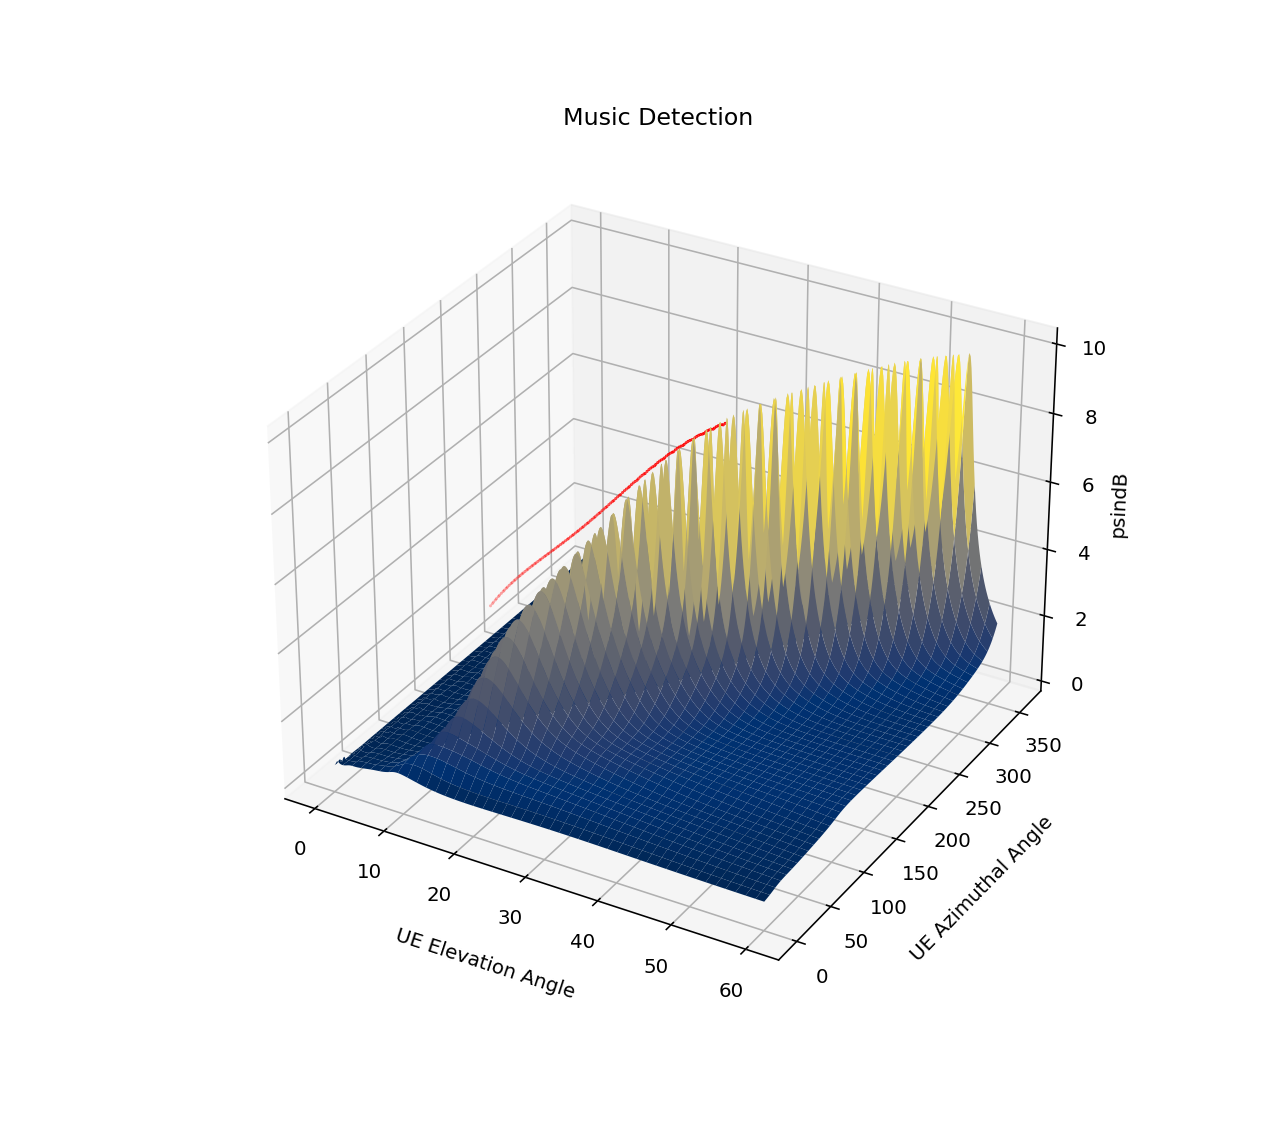

maximum psindB value: 8.989537884773945
peak reached at: [35.097493036211695, 206.57381615598882]
actual UE direction: [[53.571609086160095, 295.64248430081943]]


In [7]:
# %matplotlib notebook
fig = plt.figure(figsize = (9,8))
ax = plt.axes(projection='3d')
# DoAsMUSIC,_= ss.find_peaks(psindB)
DoAsMUSIC,_ = ss.find_peaks(psindB, height=[4,9], distance=1.5)

X, Y = np.meshgrid(p_angles, az_angles)
Z = psindB[:129600].reshape(len(p_angles),len(p_angles))

surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)

Xs = np.array(general_angles)[DoAsMUSIC][:,0]
Ys = np.array(general_angles)[DoAsMUSIC][:,1]
Zs = psindB[DoAsMUSIC]
ax.scatter(Xs,Ys,Zs,color='r',marker='.',s=1)

# Set axes label
ax.set_xlabel('UE Elevation Angle', labelpad=10)
ax.set_ylabel('UE Azimuthal Angle', labelpad=10)
ax.set_zlabel('psindB', labelpad=1)
ax.set_title("Music Detection")
print('maximum psindB value:',psindB[DoAsMUSIC].max())
print('peak reached at:',general_angles[DoAsMUSIC[np.argmax(psindB[DoAsMUSIC])]])
print('actual UE direction:',ue_angles)
# fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

In [12]:
%%time
signal_samples = 10
indies = np.argsort(psindB[DoAsMUSIC])[-1*signal_samples:]
samples = np.array(general_angles)[DoAsMUSIC][indies]

# sinr = SINR(ris_alphas,ue_alphas,ris_data=ris_angles+ris_vectors,ue_angles=samples, snr=1)
sinr = SINR(ris_power = ris_alphas,
            ue_power = ue_alphas,
            ue_angles = samples,
            ris_data = ris_angles+ris_vectors,
#             model = model,
#             vector = vector_check,
#             angle = angle_check,
            snr = 100)
detected_ue_angles = samples[np.argmax(sinr)].tolist()
print('detected angles for user equipment:',detected_ue_angles)
print('actual UE direction:',ue_angles)
print('with maximum SINR:',np.max(sinr))
print()

detected angles for user equipment: [34.428969359331475, 203.56545961002783]
actual UE direction: [[53.571609086160095, 295.64248430081943]]
with maximum SINR: 20.307834794223258

CPU times: user 425 ms, sys: 20.3 ms, total: 445 ms
Wall time: 198 ms


# NSB Algorithm

In [15]:
numrealization = 100 # number of time samples collected at antenna array
tm.start(message='preparing covariance matrix by NSB')
H = np.zeros((n_antenna,numrealization)) + 1j*np.zeros((n_antenna,numrealization))
print('H matrix shape(n_antenna,time_instance):',H.shape)
antenna_weight = nsb(P,Q, wavelength=lamda, pos_angles=ris_angles+ue_angles).reshape(-1,)

for iter in range(numrealization):
    # random distortions due to propagation medium
    #ris
    distortion_ris = np.exp(1j*2*np.pi*np.random.rand(1)) 
    recieved_power_ris = distortion_ris*ris_alphas*antenna_weight
    #ue
    distortion_ue = np.exp(1j*2*np.pi*np.random.rand(1))
    recieved_power_ue = distortion_ue*ue_alphas*antenna_weight
    
    net_recieved_power = recieved_power_ris+recieved_power_ue
    noise = np.sqrt(0.5/snr)*(np.random.randn(n_antenna)+np.random.randn(n_antenna)*1j)
    H[:,iter] = net_recieved_power+noise
CovMat = H@H.conj().transpose()
print('covariance matrix shape:',CovMat.shape)
tm.end()

H matrix shape(n_antenna,time_instance): (64, 100)
covariance matrix shape: (64, 64)

>> preparing covariance matrix by NSB: Done!! Time taken: 0.7945 sec


In [17]:
%%time

# MUSIC algorithm

DoAsMUSIC, psindB = music(CovMat,
                          L = n_source,
                          N = n_antenna,
                          angles = general_angles,
                          ris_data = ris_angles+ris_vectors,
                          height=[7, 9],
                          method='nsb')

Processing Angles:   0%|          | 0/129600 [00:00<?, ?it/s]

CPU times: user 1min 20s, sys: 529 ms, total: 1min 21s
Wall time: 1min 20s


<IPython.core.display.Javascript object>


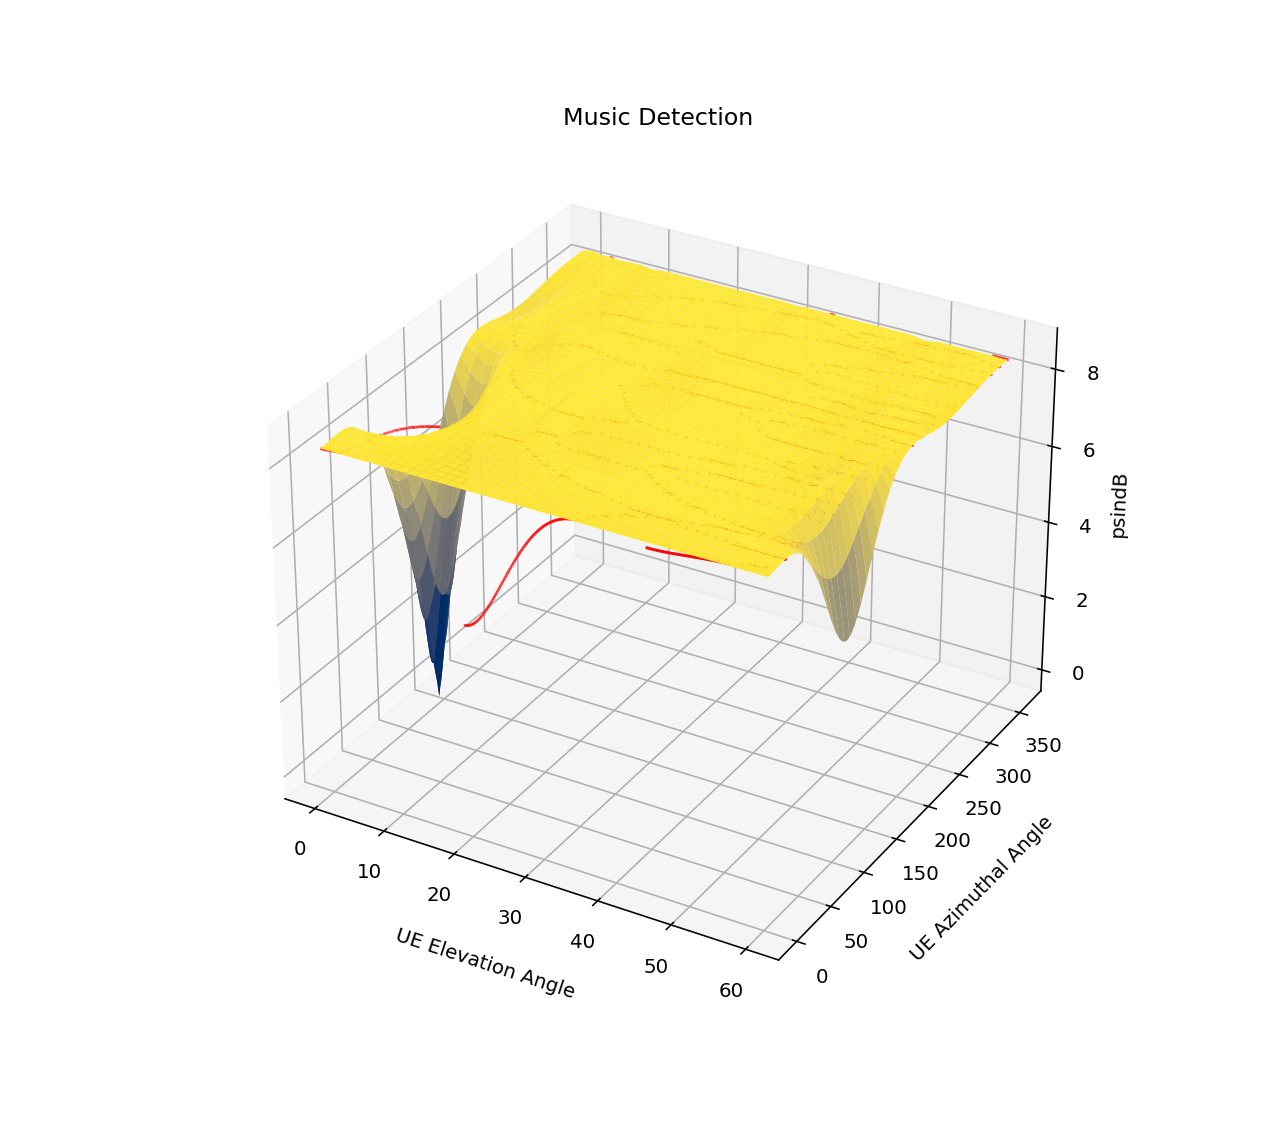

maximum psindB value: 8.440360723847796
peak reached at: [59.99999999999999, 8.022284122562674]
actual UE direction: [[53.571609086160095, 295.64248430081943]]


In [18]:
# %matplotlib notebook
fig = plt.figure(figsize = (9,8))
ax = plt.axes(projection='3d')
# DoAsMUSIC,_= ss.find_peaks(psindB)
DoAsMUSIC,_ = ss.find_peaks(psindB, height=[4,9], distance=1.5)

X, Y = np.meshgrid(p_angles, az_angles)
Z = psindB[:129600].reshape(len(p_angles),len(p_angles))

surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)

Xs = np.array(general_angles)[DoAsMUSIC][:,0]
Ys = np.array(general_angles)[DoAsMUSIC][:,1]
Zs = psindB[DoAsMUSIC]
ax.scatter(Xs,Ys,Zs,color='r',marker='.',s=1)

# Set axes label
ax.set_xlabel('UE Elevation Angle', labelpad=10)
ax.set_ylabel('UE Azimuthal Angle', labelpad=10)
ax.set_zlabel('psindB', labelpad=1)
ax.set_title("Music Detection")
print('maximum psindB value:',psindB[DoAsMUSIC].max())
print('peak reached at:',general_angles[DoAsMUSIC[np.argmax(psindB[DoAsMUSIC])]])
print('actual UE direction:',ue_angles)
# fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

In [21]:
%%time
signal_samples = 10
indies = np.argsort(psindB[DoAsMUSIC])[-1*signal_samples:]
samples = np.array(general_angles)[DoAsMUSIC][indies]

# sinr = SINR(ris_alphas,ue_alphas,ris_data=ris_angles+ris_vectors,ue_angles=samples, snr=1)
sinr = SINR(ris_power = ris_alphas,
            ue_power = ue_alphas,
            ue_angles = samples,
            ris_data = ris_angles+ris_vectors,
            snr = 10)
detected_ue_angles = samples[np.argmax(sinr)].tolist()
print('detected angles for user equipment:',detected_ue_angles)
print('actual UE direction:',ue_angles)
print('with maximum SINR:',np.max(sinr))
print()

detected angles for user equipment: [50.47353760445682, 166.46239554317546]
actual UE direction: [[53.571609086160095, 295.64248430081943]]
with maximum SINR: 19.941919157333203

CPU times: user 234 ms, sys: 0 ns, total: 234 ms
Wall time: 91.4 ms


# Capon Method

In [23]:
M = P*Q # number of antenna elements (sensors)
pos_angles = ris_angles+ue_angles
Rss = np.eye((2))# correlation matrix of the information symbols
Rnn = 0.1*np.eye((M))# correlation matrix of additive noise
A = find_steering_matrix(wavelength=lamda, pos_angles=pos_angles, planar_antenna_shape=(P,Q)) # steering vectors
R = A @ Rss @ np.conj(A).T + Rnn # correlation matrix
g = np.array([1,1]) # gate array: both DoAs are "switched on"

In [26]:
numrealization = 100 # number of time samples collected at antenna array
tm.start(message='preparing covariance matrix by Capon')
H = np.zeros((n_antenna,numrealization)) + 1j*np.zeros((n_antenna,numrealization))
print('H matrix shape(n_antenna,time_instance):',H.shape)
antenna_weight = capon(A,R,g)

for iter in range(numrealization):
    # random distortions due to propagation medium
    #ris
    distortion_ris = np.exp(1j*2*np.pi*np.random.rand(1)) 
    recieved_power_ris = distortion_ris*ris_alphas*antenna_weight
    #ue
    distortion_ue = np.exp(1j*2*np.pi*np.random.rand(1))
    recieved_power_ue = distortion_ue*ue_alphas*antenna_weight
    
    net_recieved_power = recieved_power_ris+recieved_power_ue
    noise = np.sqrt(0.5/snr)*(np.random.randn(n_antenna)+np.random.randn(n_antenna)*1j)
    H[:,iter] = net_recieved_power+noise
CovMat = H@H.conj().transpose()
print('covariance matrix shape:',CovMat.shape)
tm.end()

H matrix shape(n_antenna,time_instance): (64, 100)
covariance matrix shape: (64, 64)

>> preparing covariance matrix by Capon: Done!! Time taken: 0.2469 sec


In [27]:
%%time

# MUSIC algorithm

DoAsMUSIC, psindB = music(CovMat,
                          L = n_source,
                          N = n_antenna,
                          angles = general_angles,
                          ris_data = ris_angles+ris_vectors,
                          height=[7, 9],
                          method='capon')

Processing Angles:   0%|          | 0/129600 [00:00<?, ?it/s]

CPU times: user 9min 51s, sys: 6.13 s, total: 9min 57s
Wall time: 2min 32s


<IPython.core.display.Javascript object>


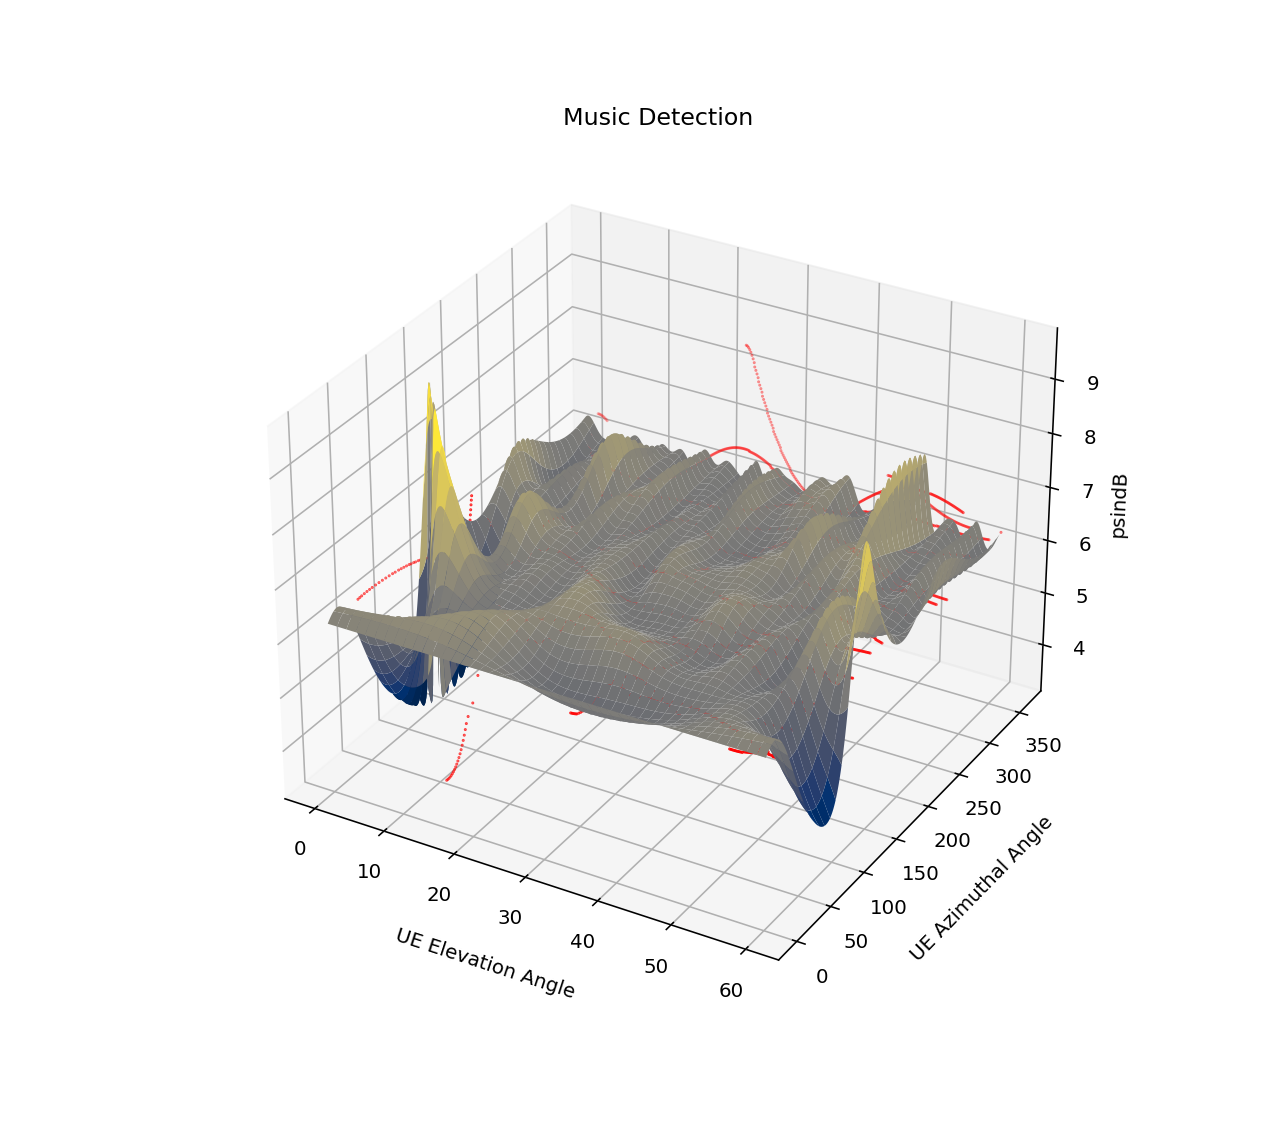

maximum psindB value: 8.993105670568866
peak reached at: [18.21727019498607, 25.069637883008355]
actual UE direction: [[53.571609086160095, 295.64248430081943]]


In [28]:
# %matplotlib notebook
fig = plt.figure(figsize = (9,8))
ax = plt.axes(projection='3d')
# DoAsMUSIC,_= ss.find_peaks(psindB)
DoAsMUSIC,_ = ss.find_peaks(psindB, height=[4,9], distance=1.5)

X, Y = np.meshgrid(p_angles, az_angles)
Z = psindB[:129600].reshape(len(p_angles),len(p_angles))

surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)

Xs = np.array(general_angles)[DoAsMUSIC][:,0]
Ys = np.array(general_angles)[DoAsMUSIC][:,1]
Zs = psindB[DoAsMUSIC]
ax.scatter(Xs,Ys,Zs,color='r',marker='.',s=1)

# Set axes label
ax.set_xlabel('UE Elevation Angle', labelpad=10)
ax.set_ylabel('UE Azimuthal Angle', labelpad=10)
ax.set_zlabel('psindB', labelpad=1)
ax.set_title("Music Detection")
print('maximum psindB value:',psindB[DoAsMUSIC].max())
print('peak reached at:',general_angles[DoAsMUSIC[np.argmax(psindB[DoAsMUSIC])]])
print('actual UE direction:',ue_angles)
# fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

In [29]:
%%time
signal_samples = 10
indies = np.argsort(psindB[DoAsMUSIC])[-1*signal_samples:]
samples = np.array(general_angles)[DoAsMUSIC][indies]

# sinr = SINR(ris_alphas,ue_alphas,ris_data=ris_angles+ris_vectors,ue_angles=samples, snr=1)
sinr = SINR(ris_power = ris_alphas,
            ue_power = ue_alphas,
            ue_angles = samples,
            ris_data = ris_angles+ris_vectors,
            snr = 10)
detected_ue_angles = samples[np.argmax(sinr)].tolist()
print('detected angles for user equipment:',detected_ue_angles)
print('actual UE direction:',ue_angles)
print('with maximum SINR:',np.max(sinr))
print()

detected angles for user equipment: [17.883008356545957, 27.07520891364902]
actual UE direction: [[53.571609086160095, 295.64248430081943]]
with maximum SINR: 19.96777015788904

CPU times: user 210 ms, sys: 4.13 ms, total: 214 ms
Wall time: 83 ms


# Bartlett's Method

In [30]:
M = P*Q # number of antenna elements (sensors)
A = find_steering_matrix(wavelength=lamda, pos_angles=pos_angles, planar_antenna_shape=(P,Q)) # steering vectors

In [31]:
numrealization = 100 # number of time samples collected at antenna array
tm.start(message='preparing covariance matrix by Bartlett')
H = np.zeros((n_antenna,numrealization)) + 1j*np.zeros((n_antenna,numrealization))
print('H matrix shape(n_antenna,time_instance):',H.shape)
antenna_weight = np.average(A,axis=1)/M

for iter in range(numrealization):
    # random distortions due to propagation medium
    #ris
    distortion_ris = np.exp(1j*2*np.pi*np.random.rand(1)) 
    recieved_power_ris = distortion_ris*ris_alphas*antenna_weight
    #ue
    distortion_ue = np.exp(1j*2*np.pi*np.random.rand(1))
    recieved_power_ue = distortion_ue*ue_alphas*antenna_weight
    
    net_recieved_power = recieved_power_ris+recieved_power_ue
    noise = np.sqrt(0.5/snr)*(np.random.randn(n_antenna)+np.random.randn(n_antenna)*1j)
    H[:,iter] = net_recieved_power+noise
CovMat = H@H.conj().transpose()
print('covariance matrix shape:',CovMat.shape)
tm.end()

H matrix shape(n_antenna,time_instance): (64, 100)
covariance matrix shape: (64, 64)

>> preparing covariance matrix by Bartlett: Done!! Time taken: 0.0066 sec


In [50]:
%%time

# MUSIC algorithm

DoAsMUSIC, psindB = music(CovMat,
                          L = n_source,
                          N = n_antenna,
                          angles = general_angles,
                          ris_data = ris_angles+ris_vectors,
                          height=[7, 9],
                          method='bartlett')

Processing Angles:   0%|          | 0/129600 [00:00<?, ?it/s]

CPU times: user 9min 24s, sys: 5.4 s, total: 9min 29s
Wall time: 2min 22s


<IPython.core.display.Javascript object>


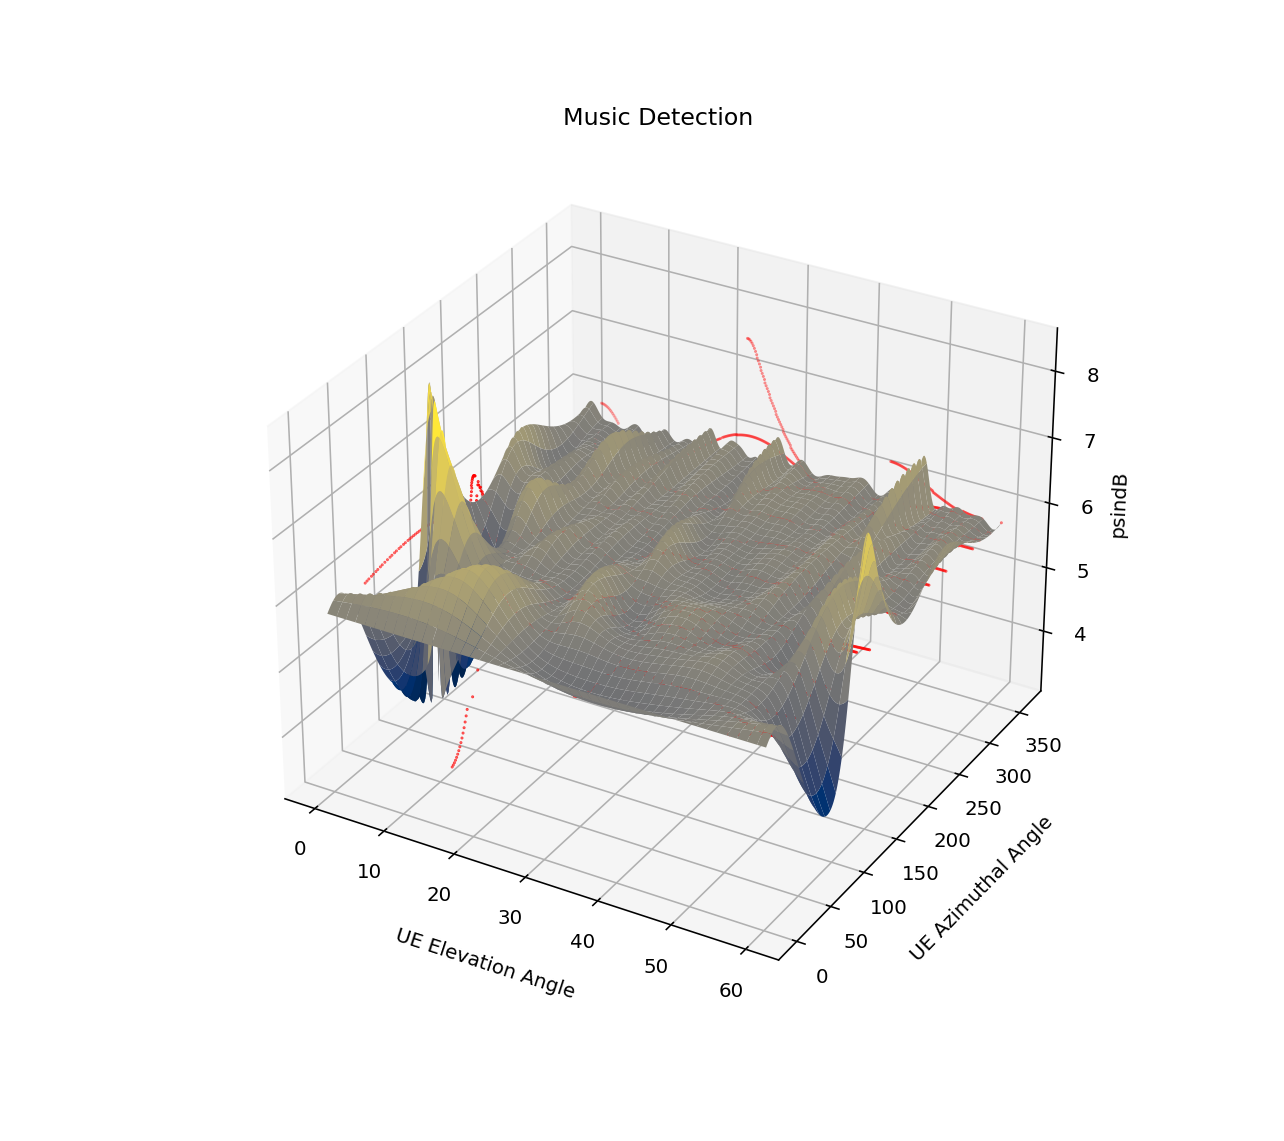

maximum psindB value: 8.285585662805556
peak reached at: [19.721448467966574, 16.044568245125348]
actual UE direction: [[53.571609086160095, 295.64248430081943]]


In [51]:
# %matplotlib notebook
fig = plt.figure(figsize = (9,8))
ax = plt.axes(projection='3d')
# DoAsMUSIC,_= ss.find_peaks(psindB)
DoAsMUSIC,_ = ss.find_peaks(psindB, height=[4,9], distance=1.5)

X, Y = np.meshgrid(p_angles, az_angles)
Z = psindB[:129600].reshape(len(p_angles),len(p_angles))

surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)

Xs = np.array(general_angles)[DoAsMUSIC][:,0]
Ys = np.array(general_angles)[DoAsMUSIC][:,1]
Zs = psindB[DoAsMUSIC]
ax.scatter(Xs,Ys,Zs,color='r',marker='.',s=1)

# Set axes label
ax.set_xlabel('UE Elevation Angle', labelpad=10)
ax.set_ylabel('UE Azimuthal Angle', labelpad=10)
ax.set_zlabel('psindB', labelpad=1)
ax.set_title("Music Detection")
print('maximum psindB value:',psindB[DoAsMUSIC].max())
print('peak reached at:',general_angles[DoAsMUSIC[np.argmax(psindB[DoAsMUSIC])]])
print('actual UE direction:',ue_angles)
# fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

In [52]:
%%time
signal_samples = 10
indies = np.argsort(psindB[DoAsMUSIC])[-1*signal_samples:]
samples = np.array(general_angles)[DoAsMUSIC][indies]

# sinr = SINR(ris_alphas,ue_alphas,ris_data=ris_angles+ris_vectors,ue_angles=samples, snr=1)
sinr = SINR(ris_power = ris_alphas,
            ue_power = ue_alphas,
            ue_angles = samples,
            ris_data = ris_angles+ris_vectors,
            snr = 10)
detected_ue_angles = samples[np.argmax(sinr)].tolist()
print('detected angles for user equipment:',detected_ue_angles)
print('actual UE direction:',ue_angles)
print('with maximum SINR:',np.max(sinr))
print()

detected angles for user equipment: [19.220055710306404, 19.05292479108635]
actual UE direction: [[53.571609086160095, 295.64248430081943]]
with maximum SINR: 19.913531634749663

CPU times: user 246 ms, sys: 3.99 ms, total: 250 ms
Wall time: 94.4 ms
